# 📌 Introduction to Recurrent Neural Networks (RNNs)  
Recurrent Neural Networks (RNNs) are a class of neural networks designed to handle **sequential data** by maintaining a memory of past inputs.  
They are widely used in **natural language processing (NLP), time-series forecasting, and speech recognition**.  

Unlike traditional feedforward neural networks, RNNs have a recurrent connection allowing them to process variable-length sequences.

## 🛠 About This Notebook  
In this notebook, we implement a **basic One-to-One RNN model** using TensorFlow/Keras and evaluate its performance.


In [1]:
#one to one RNN model

# 📊 Dataset Explanation  
We are using the **Digits Dataset from Scikit-Learn**, which contains images of handwritten digits (0-9).  
Each image is an 8x8 pixel grayscale image, and our goal is to classify the digit correctly.

### 🔹 Key Features:  
- **Samples:** 1797 grayscale images  
- **Classes:** 10 (digits 0-9)  
- **Feature Shape:** (8x8 pixels, flattened into 64 features per sample)  
- **Task:** Classification  


In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import sklearn.datasets as load_digits

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score

In [15]:
#Plot Function
def plot_metrics(metric_history):
  metrics = ['loss', 'accuracy']

  plt.figure(figsize=(20,10))

  for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(metric_history[metric], label='Train'+metric)
    plt.plot(metric_history[f'val_{metric}'], label='Valid'+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} over epochs')
    plt.grid(True)
    plt.legend()
  plt.tight_layout()
  plt.show()

In [4]:
from sklearn.datasets import load_digits

In [5]:
#Load and Preprocess Data
digits = load_digits()
X = digits.data
y = digits.target
num_classes = len(np.unique(y))

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], 1, X.shape[1])  #RNN Input

In [6]:
#Starified Split 80:10:10
s1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(s1.split(X, y))
X_train, X_temp = X[train_idx], X[temp_idx]
y_train, y_temp = y[train_idx], y[temp_idx]

s2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(s2.split(X_temp, y_temp))
X_val, X_test = X[train_idx], X[test_idx]
y_val, y_test = y[train_idx], y[test_idx]

In [7]:
#Model

model = models.Sequential([
    layers.SimpleRNN(64, input_shape=(1, X.shape[2]), activation='relu', kernel_regularizer=regularizers.l2(1e5)), #64 = number of rnn neurons
    layers.Dense(num_classes, activation='softmax') ])

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9 )

optimizer = optimizers.Adam(learning_rate=lr_schedule)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #monitoring validation loss
#will stop training if loss inc for 5 times

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
metrics_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

epochs = 50
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1,
                        batch_size=32,
                        verbose=1)

    # Log metrics
    logs = {k: v[0] for k, v in history.history.items()}  # Ensure values exist
    for k in logs:
        metrics_history[k].append(logs[k])

    # Predictions
    y_train_pred = np.argmax(model.predict(X_train, verbose=0), axis=1)
    y_val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

    # Classification Reports
    print(f"\nEpoch {epoch + 1} - Training Metrics:")
    print(classification_report(y_train, y_train_pred, digits=4))

    print(f"\nEpoch {epoch + 1} - Validation Metrics:")
    print(classification_report(y_val, y_val_pred, digits=4))

    # Early stopping check
    if early_stopping.stopped_epoch > 0:
        break


#FINAL CONFUSION METRICS
y_train_pred = np.argmax(model.predict(X_train, verbose=0), axis=1)
y_val_pred = np.argmax(model.predict(X_val, verbose = 0), axis=1)
y_test_pred = np.argmax(model.predict(X_test, verbose = 0), axis=1)


print("\nFinal Confusion Matrix - Train: ")
print(confusion_matrix(y_train, y_train_pred))

print("\nFinal Confusion Matrix - Validation: ")
print(confusion_matrix(y_val, y_val_pred))

print("\nFinal Confusion Matrix - Test: ")
print(confusion_matrix(y_test, y_test_pred))


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1299 - loss: 5615671.5000 - val_accuracy: 0.2444 - val_loss: 3367703.0000

Epoch 1 - Training Metrics:
              precision    recall  f1-score   support

           0     0.5223    0.5775    0.5485       142
           1     0.1691    0.1575    0.1631       146
           2     0.1851    0.5423    0.2760       142
           3     0.1818    0.2192    0.1988       146
           4     0.4709    0.7241    0.5707       145
           5     0.0300    0.0207    0.0245       145
           6     0.1887    0.0690    0.1010       145
           7     0.1000    0.0490    0.0657       143
           8     0.2381    0.0719    0.1105       139
           9     0.1719    0.0764    0.1058       144

    accuracy                         0.2505      1437
   macro avg     0.2258    0.2508    0.2165      1437
weighted avg     0.2253    0.2505    0.2163      1437


Epoch 1 - Validation Metrics:
              precision    recall  f1-sco

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3382 - loss: 515.5458 - val_accuracy: 0.2167 - val_loss: 192.7257

Epoch 11 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.7500    0.0205    0.0400       146
           2     0.0000    0.0000    0.0000       142
           3     0.1589    0.9863    0.2738       146
           4     0.2708    0.9448    0.4209       145
           5     0.0000    0.0000    0.0000       145
           6     0.7778    0.0966    0.1718       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.2074      1437
   macro avg     0.1957    0.2048    0.0906      1437
weighted avg     0.1982    0.2074    0.0917      1437


Epoch 11 - Validation Metrics:
              precision    recall  f1-score   support

     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2747 - loss: 145.1481 - val_accuracy: 0.0889 - val_loss: 52.5394

Epoch 12 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1020    1.0000    0.1850       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0185      1437
weighted avg     0.0104    0.1016    0.0188      1437


Epoch 12 - Validation Metrics:
              precision    recall  f1-score   support

      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1328 - loss: 39.5133 - val_accuracy: 0.1167 - val_loss: 14.6985

Epoch 13 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1044    1.0000    0.1890       146
           4     0.0000    0.0000    0.0000       145
           5     0.3158    0.0828    0.1311       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1100      1437
   macro avg     0.0420    0.1083    0.0320      1437
weighted avg     0.0425    0.1100    0.0324      1437


Epoch 13 - Validation Metrics:
              precision    recall  f1-score   support

       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1133 - loss: 11.3692 - val_accuracy: 0.0889 - val_loss: 5.1622

Epoch 14 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     1.0000    0.0411    0.0789       146
           2     0.0000    0.0000    0.0000       142
           3     0.1020    1.0000    0.1852       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1058      1437
   macro avg     0.1102    0.1041    0.0264      1437
weighted avg     0.1120    0.1058    0.0268      1437


Epoch 14 - Validation Metrics:
              precision    recall  f1-score   support

        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1120 - loss: 4.3676 - val_accuracy: 0.0778 - val_loss: 2.9195

Epoch 15 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 15 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0932 - loss: 2.7417 - val_accuracy: 0.0889 - val_loss: 2.4269

Epoch 16 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 16 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1070 - loss: 2.3893 - val_accuracy: 0.0778 - val_loss: 2.3265

Epoch 17 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 17 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0977 - loss: 2.3192 - val_accuracy: 0.0889 - val_loss: 2.3072

Epoch 18 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 18 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1012 - loss: 2.3051 - val_accuracy: 0.1111 - val_loss: 2.3042

Epoch 19 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 19 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0870 - loss: 2.3036 - val_accuracy: 0.0778 - val_loss: 2.3036

Epoch 20 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 20 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0933 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3033

Epoch 21 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.1009    1.0000    0.1833       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 21 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1127 - loss: 2.3024 - val_accuracy: 0.0889 - val_loss: 2.3047

Epoch 22 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 22 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1075 - loss: 2.3032 - val_accuracy: 0.1111 - val_loss: 2.3032

Epoch 23 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 23 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0911 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3033

Epoch 24 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.1009    1.0000    0.1833       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 24 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0766 - loss: 2.3033 - val_accuracy: 0.0889 - val_loss: 2.3027

Epoch 25 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 25 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0954 - loss: 2.3024 - val_accuracy: 0.0778 - val_loss: 2.3036

Epoch 26 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 26 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1044 - loss: 2.3027 - val_accuracy: 0.1111 - val_loss: 2.3028

Epoch 27 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 27 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1050 - loss: 2.3027 - val_accuracy: 0.1111 - val_loss: 2.3032

Epoch 28 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 28 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1017 - loss: 2.3035 - val_accuracy: 0.0889 - val_loss: 2.3036

Epoch 29 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 29 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0880 - loss: 2.3029 - val_accuracy: 0.0778 - val_loss: 2.3038

Epoch 30 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 30 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1034 - loss: 2.3024 - val_accuracy: 0.0889 - val_loss: 2.3040

Epoch 31 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 31 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1068 - loss: 2.3038 - val_accuracy: 0.1056 - val_loss: 2.3026

Epoch 32 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.1009    1.0000    0.1833       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 32 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1112 - loss: 2.3033 - val_accuracy: 0.1111 - val_loss: 2.3039

Epoch 33 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 33 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1061 - loss: 2.3030 - val_accuracy: 0.1111 - val_loss: 2.3039

Epoch 34 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 34 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1045 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3037

Epoch 35 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.1009    1.0000    0.1833       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 35 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0963 - loss: 2.3038 - val_accuracy: 0.1056 - val_loss: 2.3031

Epoch 36 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.1009    1.0000    0.1833       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 36 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1009 - loss: 2.3037 - val_accuracy: 0.1000 - val_loss: 2.3034

Epoch 37 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.1009    1.0000    0.1833       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 37 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0963 - loss: 2.3028 - val_accuracy: 0.0778 - val_loss: 2.3041

Epoch 38 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 38 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1009 - loss: 2.3037 - val_accuracy: 0.0778 - val_loss: 2.3037

Epoch 39 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 39 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0955 - loss: 2.3031 - val_accuracy: 0.0778 - val_loss: 2.3039

Epoch 40 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 40 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1008 - loss: 2.3035 - val_accuracy: 0.0889 - val_loss: 2.3034

Epoch 41 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 41 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0974 - loss: 2.3032 - val_accuracy: 0.0833 - val_loss: 2.3040

Epoch 42 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.1002    1.0000    0.1822       144

    accuracy                         0.1002      1437
   macro avg     0.0100    0.1000    0.0182      1437
weighted avg     0.0100    0.1002    0.0183      1437


Epoch 42 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0803 - loss: 2.3035 - val_accuracy: 0.0889 - val_loss: 2.3038

Epoch 43 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 43 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0816 - loss: 2.3031 - val_accuracy: 0.0889 - val_loss: 2.3045

Epoch 44 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 44 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0786 - loss: 2.3032 - val_accuracy: 0.1111 - val_loss: 2.3036

Epoch 45 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.1009    1.0000    0.1833       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 45 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0886 - loss: 2.3037 - val_accuracy: 0.0778 - val_loss: 2.3053

Epoch 46 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 46 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1146 - loss: 2.3041 - val_accuracy: 0.0889 - val_loss: 2.3028

Epoch 47 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 47 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0889 - loss: 2.3032 - val_accuracy: 0.0889 - val_loss: 2.3044

Epoch 48 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.1016    1.0000    0.1845       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 48 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0948 - loss: 2.3038 - val_accuracy: 0.1056 - val_loss: 2.3040

Epoch 49 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.0000    0.0000    0.0000       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.1009    1.0000    0.1833       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1009      1437
   macro avg     0.0101    0.1000    0.0183      1437
weighted avg     0.0102    0.1009    0.0185      1437


Epoch 49 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1103 - loss: 2.3036 - val_accuracy: 0.0778 - val_loss: 2.3045

Epoch 50 - Training Metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.1016    1.0000    0.1845       146
           2     0.0000    0.0000    0.0000       142
           3     0.0000    0.0000    0.0000       146
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       145
           6     0.0000    0.0000    0.0000       145
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000       139
           9     0.0000    0.0000    0.0000       144

    accuracy                         0.1016      1437
   macro avg     0.0102    0.1000    0.0184      1437
weighted avg     0.0103    0.1016    0.0187      1437


Epoch 50 - Validation Metrics:
              precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Final Confusion Matrix - Train: 
[[  0 142   0   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0   0   0]
 [  0 142   0   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0   0   0]
 [  0 145   0   0   0   0   0   0   0   0]
 [  0 145   0   0   0   0   0   0   0   0]
 [  0 145   0   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0   0   0]
 [  0 139   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]]

Final Confusion Matrix - Validation: 
[[ 0 21  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]]

Final Confusion Matrix - Test: 
[[ 0 17  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0]


# 📈 Model Summary & Results  
### 🔹 Evaluation Metrics Used:  
- **Accuracy**: Measures overall correctness of predictions  
- **Precision**: Fraction of correctly predicted positive observations  
- **Recall**: Ability of the model to capture all positive observations  
- **F1-Score**: Balance between precision and recall  
- **Confusion Matrix**: Visual representation of model performance across classes  

Additionally, we visualize the **loss and accuracy curves** to monitor model training progress.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.13      1.00      0.24        24
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        19

    accuracy                           0.13       180
   macro avg       0.01      0.10      0.02       180
weighted avg       0.02      0.13      0.03       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


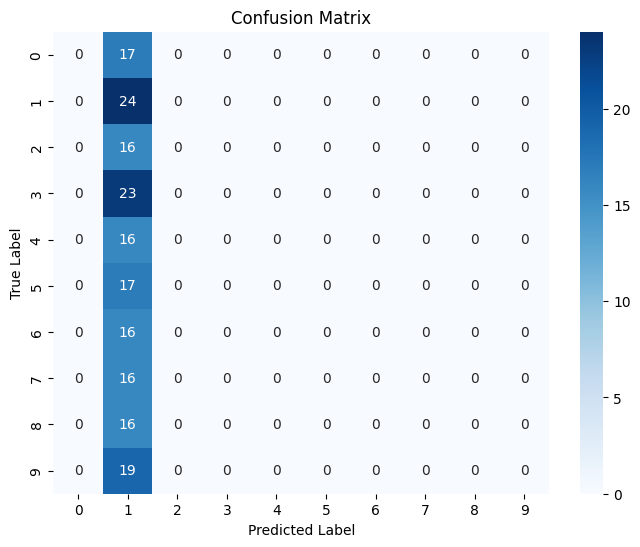

In [9]:
# Model Evaluation: Accuracy, Precision, Recall, F1-Score

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


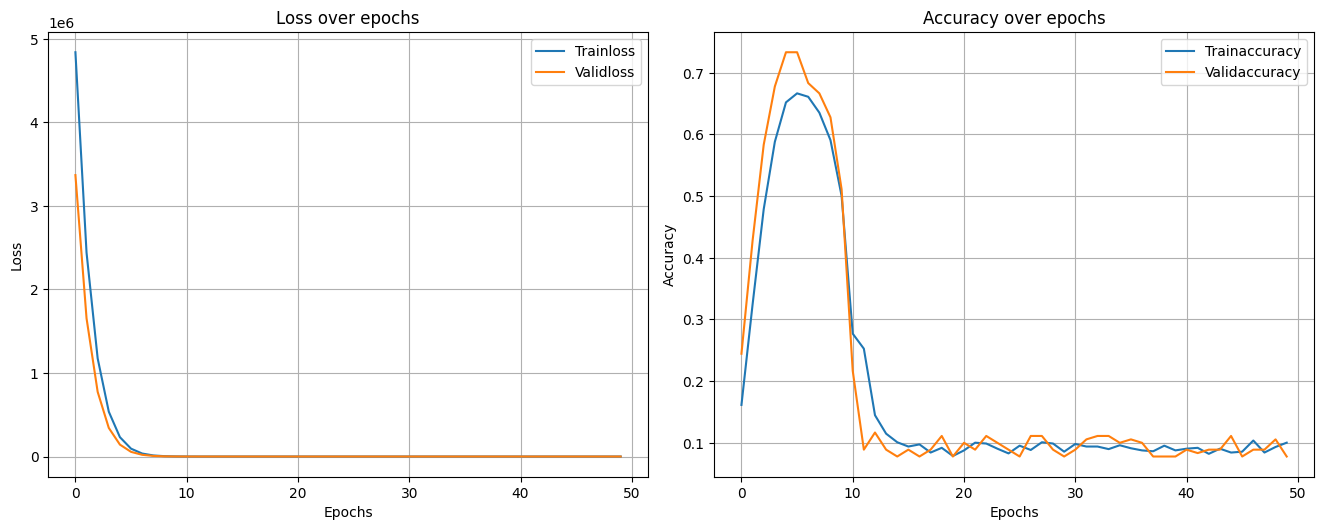

In [16]:
# Visualizing Loss & Accuracy
plot_metrics(metrics_history)